<a href="https://colab.research.google.com/github/RaviChandraVeeramachaneni/fastexp_chap2_bear_classifier/blob/main/chap_2_exp_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install the fastbook

In [ ]:
!pip install -Uqq fastbook

     |████████████████████████████████| 727kB 14.2MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 194kB 28.2MB/s 
     |████████████████████████████████| 1.2MB 31.7MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 


## Setting up the fastbook

In [ ]:
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


## Import the needed

In [ ]:
import fastbook
from fastai.vision.all import * 
from fastai.vision.widgets import *
from tqdm import tqdm

### Function needed to locate the images & wrap them to list of url's

In [ ]:
def search_images_ddg(term, max_images=200):
    "Search for `term` with DuckDuckGo and return a unique urls of about `max_images` images"
    assert max_images<1000
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term}, decode=False).decode()
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    assert searchObj
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        try:
            data = urljson(requestUrl,data=params)
            urls.update(L(data['results']).itemgot('image'))
            requestUrl = url + data['next']
        except (URLError,HTTPError): pass
        time.sleep(0.2)
    return L(urls)

In [ ]:
urls = search_images_ddg('grizzly bear', max_images=100)
urls

(#100) ['https://www.conservationnw.org/wp-content/uploads/2017/06/Grizzly-bear-family-Copyright-iStock.com_PhotosbyAndy-4.2015-e1507229404830.jpg','https://keyassets.timeincuk.net/inspirewp/live/wp-content/uploads/sites/2/2019/06/GettyImages-525103104.jpg','https://a57.foxnews.com/a57.foxnews.com/static.foxnews.com/foxnews.com/content/uploads/2018/09/640/320/1862/1048/Grizzly-iStock.jpg?ve=1&tl=1?ve=1&tl=1','https://wallsdesk.com/wp-content/uploads/2017/01/Grizzly-Bear-Desktop-Wallpaper-.jpg','http://static.independent.co.uk/s3fs-public/thumbnails/image/2016/06/30/08/yellowstone-grizzly-bear-.jpg','https://bozone.com/site/wp-content/uploads/2019/03/GRIZZLY.jpeg','https://wallsdesk.com/wp-content/uploads/2017/01/Grizzly-Bear-Background-.jpg','https://www.thefencepost.com/wp-content/uploads/sites/12/2018/08/grizzlies-tsln-081118-1240x828.jpg','https://www.rmef.org/wp-content/uploads/2020/05/wyoming-grizzly-bear.jpg','https://2.bp.blogspot.com/-p-QKKk3T8O0/UQN3a5YSALI/AAAAAAAAFcE/iTlNg3j

In [ ]:
### Creating the needed categories

In [ ]:
bear_types = ['grizzly', 'teddy', 'black']

In [ ]:
path = Path('./bear')

### Download the images

In [ ]:
if not path.exists():
    path.mkdir()
    for o in tqdm(bear_types):
        dest = (path/o)
        results = search_images_ddg(f'{o} bear', max_images=100)  
        images = download_images(dest, urls=results)

100%|██████████| 3/3 [00:48<00:00, 16.26s/it]


In [ ]:
fns = get_image_files(path)
fns

(#255) [Path('bear/grizzly/00000096.jpg'),Path('bear/grizzly/00000091.jpg'),Path('bear/grizzly/00000014.jpg'),Path('bear/grizzly/00000075.jpg'),Path('bear/grizzly/00000016.jpg'),Path('bear/grizzly/00000040.jpg'),Path('bear/grizzly/00000092.jpg'),Path('bear/grizzly/00000069.png'),Path('bear/grizzly/00000084.jpg'),Path('bear/grizzly/00000058.jpg')...]

### Verifying the failed/corruped images

In [ ]:
failed = verify_images(fns)
failed

(#9) [Path('bear/grizzly/00000032.jpg'),Path('bear/grizzly/00000050.jpg'),Path('bear/grizzly/00000010.jpg'),Path('bear/grizzly/00000063.jpg'),Path('bear/black/00000032.jpg'),Path('bear/black/00000046.png'),Path('bear/black/00000005.jpg'),Path('bear/teddy/00000077.jpg'),Path('bear/teddy/00000095.jpg')]

### Unlink the corrupted images

In [ ]:
failed.map(Path.unlink);

### Creating a dataloader for the dataset we just created
    - ImageBlock: Type for independent variable(Images)
    - CategoryBlock: Type for dependent variable (Labels/type of bear)
    - get_items: The function needed for fetching the files from the path
    - splitter: can specify a splitter like RandomSplitter that will split the data into training & validation & seed for doing that exactly same every time.
    - get_y: specifies a function like parent_label which will get the folder where the files are in
    - item_tfms: Item transformation to resize all the images to the same size.

In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

### FastAI specific to get the images from the folder using the datablock object

In [ ]:
dls = bears.dataloaders(path)

#### show_batch can be used to show a batch of images from the default fastai batch size of 64 

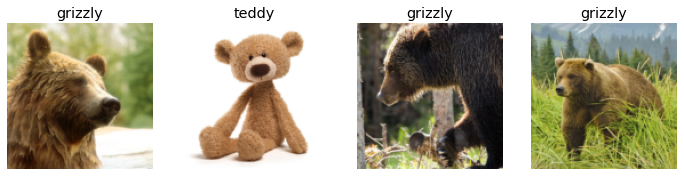

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

### Below five cells are different techniques to manipulate images

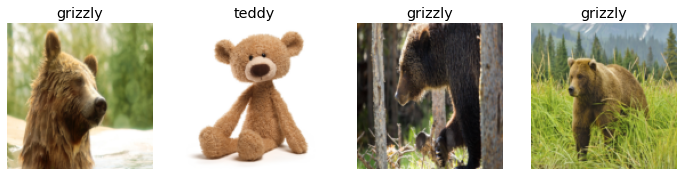

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

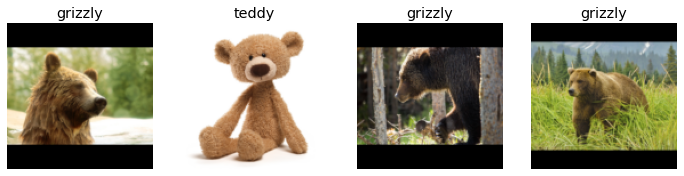

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

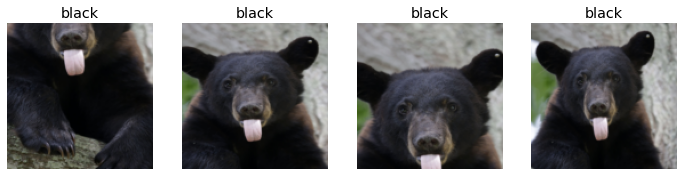

In [ ]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


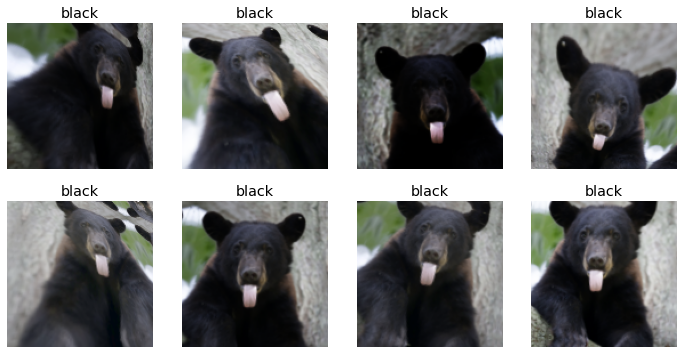

In [ ]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

#### Data Augumentation to create variations of our data without actually changing the meaning of the data.

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

## Creating a Learner Object which is a Convolutional Network and holds which cnn algorithm to use for the training
### Learner Object:
    - dls: dataloader object
    - arch: Algorithm used for training
    - metrics: whihc metrics to used for training for us to understand.
### fine_tune(<num_of_epochs>): Number of times to go through the whole image data set once.

Note: A Epoch is one cycle when the training has been done on all images.

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.256651,0.270049,0.081633,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.319335,0.105622,0.040816,00:10
1,0.230588,0.027523,0.020408,00:09
2,0.161522,0.030147,0.020408,00:10
3,0.127097,0.036481,0.020408,00:09


### Confusion matrix to understand what mistakes our model is making

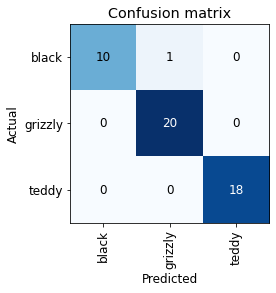

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### plot_top_losses shows the top n results with higher loss

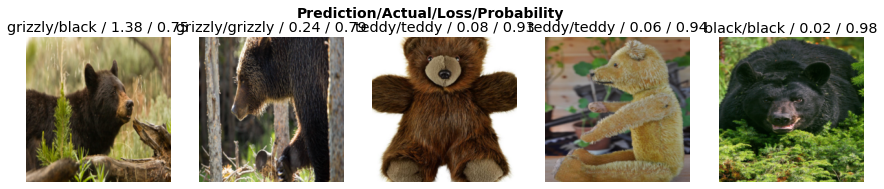

In [ ]:
interp.plot_top_losses(5, nrows=1)

### Saving a Model that can be used for production.

In [ ]:
learn.export()